In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import os 

import seaborn as sns; sns.set()

import unsupervised_helper
%aimport unsupervised_helper

vp = unsupervised_helper.VanderPlas()


In [4]:
# Create files containing charts
create = False

if create:
    pca_h = unsupervised_helper.PCA_Helper(visible=False)
    file_map = pca_h.pca_charts()
    print(file_map)

# Unsupervised Learning

- No targets
- Why use it ?
    - Understand your features
    - Better use of features in supervised models

# Plan
- Principal Components
    - Highly popular model for dimensionality reduction
- Clustering
    - K-means to cluster samples
    - Hierarchical clustering
- Recommender systems
    - Netflix prize
    - Pseudo SVD

# Alternate basis

We can find an *alternate* set of $n$ basis vectors of length $n$
$$
\tilde\v_{(1)}, \ldots, \tilde\v_{(n)}
$$
and translate $\x^\ip$ into coordinates $\tilde\x^\ip$ in the alternate basis


$$
\x^\ip = \sum_{j=1}^n { \tilde\x^\ip_j * \tilde\v_{(j)} }
$$

*Principal Components Analysis (PCA)* is a method for finding an alternate basis $
\tilde\v_{(1)}, \ldots, \tilde\v_{(n)}
$
- $\tilde\v_{(j)}$ is called *Principal Component $j$*
- That are mutually orthogonal
$$
\tilde\v_{(j)} \cdot \tilde\v_{(j')} = 0, \text{for } j \ne j'
$$
- $\tilde{\v}_{(j)}$ has more variation than $\tilde{\v}_{(j')}$ for $j \lt j'$

The number of basis vectors in the original and alternate bases is both $n$.

Suppose we reduced the number of alternate basis vectors to $r \le n$.
- We set $\tilde\x^\ip_j = 0$ for $j \gt r$

This is the *reduced dimension* approximation of $\x^\ip$.

$$
\x^\ip = \sum_{j=1}^r { \tilde\x^\ip_j * \tilde\v_{(j)} }
$$



Since the basis vectors are ordered such that $\tilde\v_{(j)}$
captures more variation than $\tilde\v_{(j')}$ for $j \lt j'$
- Dropping the alternate bases of higher index loss minimal information

PCA is the process of
- Finding alternate bases $\tilde\v$
- The alternate bases capture correlation among original features $\x$
- Projecting $\x^\ip$ onto the alternate basis $\tilde\v$ to obtain transformed vector $\tilde\x^\ip$ of synthetic features
- Choosing an $r$ so that $\tilde\x^\ip$ is of dimension $r \le n$


<img src="images/Back_to_parent.jpg">

# What is PCA

- A way to achieve dimensionality reduction
- Through the interdependence of features


As we mentioned: one use of dimensionality reduction is to find clusters of examples.
- One important difference from other methods for finding clusters
- The Decision Tree associates a cluster of examples with each node of the tree
- But the process of defining the clusters is guided by the **targets**
- Which are not present in Unsupervised Learning.




# PCA: High Level

<div class="alert alert-block alert-warning">
    <b>TL;DR</b> 
    <br>
    <ul>
        <li>PCA is a technique for creating "synthetic features" from the original set of features</li>
        <li>The synthetic features may better reveal relationships among original features</li>
        <li>May be able to use reduced set of synthetic features (dimensionality reduction)</li>
        <li>Synthetic features as a means of clustering samples</li>
        <li><strong>All features need (and will be assumed to be) centered: zero mean</strong></li>
        <li>PCA is <strong>very scale sensitive</strong>; often normalize each feature to put on same scale</li>
        </div>


The key ideas behind PCA:
- Synthetic features are more like "concepts" than simple attributes
    - Commonality of purpose rather than surface similarity
- The synthetic features are mutually *independent* (uncorrelated)
- A transformation of examples from a basis of original features to a basis of synthetic features
- Order of "importance" of synthetic features
    - Facilitates dimensionality reduction by dropping "less important" features


**Preview**

In one picture:

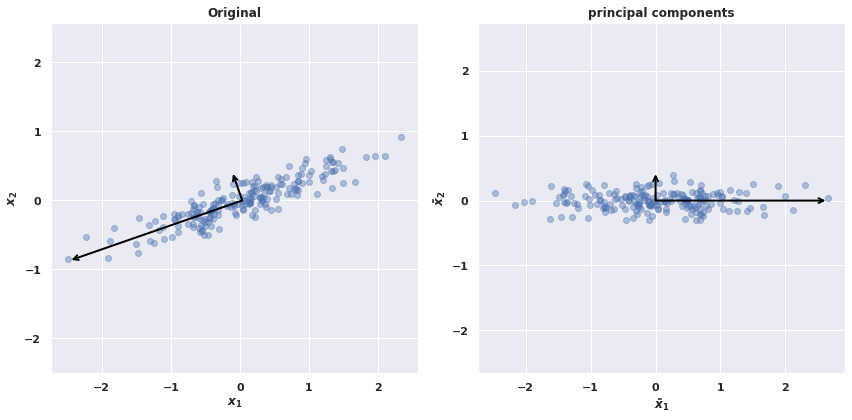

In [5]:
X = vp.create_data()

vp.show_2D(X)

The points in the left and right plots are the same, except for the coordinate system.
- Left plot: coordinate system is the horizontal and vertical axes, as usual
    - Features $\x_1, \x_2$
- Right plot: coordinate system changed
    - So that the arrowed lines of the left plot
    - Become the horizontal and vertical axes of the right plot (rotate and flip)
    - Features $\tx_1, \tx_2$


In the left plot, we can clearly see that the data set's features $\x_1, \x_2$ are correlated.

In the right plot: $\tx_1, \tx_2$ are
- Independent
- With $\tx_1$ expressed greater variation

**Note**

- The long arrowed line in the left plot
- Moves in the negative direction
- And is "flipped" to move in the positive direction of the right plot
- So the examples are the same, but rotated and flipped
    - We can more clearly see that in the examples highlighted in red

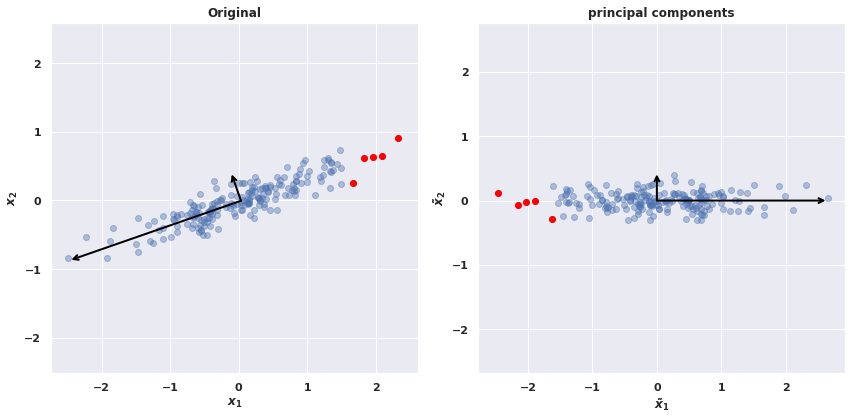

In [6]:
vp.show_2D(X, points=X[ X[:,0] > 1.5 ])

We can use matrix notation to summarize the process
$$
\X = \tilde \X V^T
$$

- The examples $\X$, expressed in the original basis
- Are the same as the examples
    - Expressed in alternate basis defined by $V$
    - With new feature values $\tilde\X$
    - When the number of new basis vectors is $n$, the number of original basis vectors

That is
- Examples $\x^\ip$ becomes $\tilde\x^\ip$
    

<img src="images/Back_to_parent.jpg">

# PCA via Matrix factorization

Our objective in this section is to show how to obtain $\tilde\X$ and $V$ such that
$$
\X = \tilde\X V^T
$$

Decomposing $\X$ into a product (as above) is called *matrix factorization*

Some types of matrix factorization we'll mention
- Singular Value Decomposition
- Eigen Decomposition
- CUR Decomposition

**Important note**

We will assume that
$\X$ has been **zero centered**: each feature value has had the mean  value of the feature (across all examples) subtracted

## Singular Value Decomposition (SVD) Factorization

Our first method for factoring $\X$ is called *Singular Value Decomposition (SVD)*.

Matrix $X$ is factored into the product of 3 matrices:
$$
\X = U \Sigma V^T
$$
- $U$: $m \times n$, columns are orthogonal unit vectors
    - $U U^T = I$
- $\Sigma: n \times n$ diagonal matrix 
$$
\text{diag}(\Sigma) = [ \sigma_1, \sigma_2, \ldots, \sigma_n ]
$$
- $V: n \times n$, columns are orthogonal unit vectors
    - $V V^T = I$
    
Moreover, the diagonal elements of $\Sigma$ are in descending order of magnitude
$$
\sigma_j > \sigma_{j'} \; \text{ for } j \lt j'
$$

Let $V^T$ be the new basis vectors
- Since $V V^T = I$ these vectors are orthogonal



We need to find the synthetic features $\tilde\X$ relative to these bases such that
$$
\X = \tilde\X V^T
$$

A little math will show us how:
$$
\begin{array}[lll]\\
\X & = & \tilde\X V^T \\
U \Sigma V^T & = & \tilde\X V^T & \text{factorization } \X = U \Sigma V^T \\
U \Sigma V^T V & = & \tilde\X V^T V & \text{multiple both sides by } V \\
U \Sigma & = & \tilde\X & \text{since } V^T V = I \\
\end{array}
$$

Thus SVD gives us both $\tilde\X$ and $V^T$ as desired.

Moreover, $\tilde\X$ being equal to
$$
\tilde\X = U \Sigma
$$
has an interesting interpretation.

Recall that $U$ is orthonormal
$$
U U^T = I
$$
so that its vectors are unit length

Since $\Sigma$ is diagonal (all zero for non-diagonal elements)
- The diagonal of $\Sigma$, denoted
$$
\text{diag}(\Sigma) = [ \sigma_1, \sigma_2, \ldots, \sigma_n ]
$$
scales the rows of $U$
$$
\begin{array}[lll]\\
\tilde\X^\ip & = & (U \Sigma)^\ip \\
 & = & U^\ip * \text{diag}(\Sigma) \\
& = & [  U^\ip_1 * \sigma_1, U^\ip_2 * \sigma_2, \ldots, U^\ip_n * \sigma_n ] \\
\end{array}
$$


Thus  
- $U$ can be thought of as a "standardized" version of features $\tilde\X$
    - Unit standard deviation
- $\tilde\X = U \Sigma$ is the non-standardized features

A picture may clarify the distinction between the standardized and non-standardized $\tilde\X$.

Here is the non-standardized $\tilde\X$ that we've seen previously

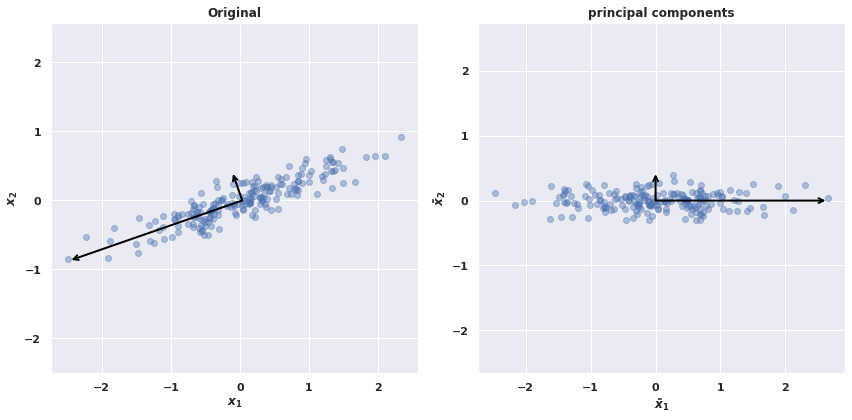

In [7]:
X = vp.create_data()

vp.show_2D(X)

And here is the standardized plot
- The length of each basis vector is $1$
- Rather than $\sigma_j$
- By stretching each component by $\sigma_j$ we recover the non-standardized plot

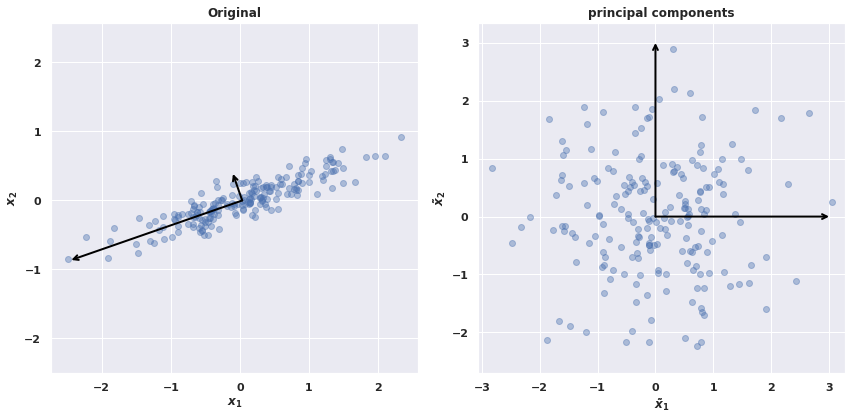

In [8]:
vp.show_2D(X, whiten=True)

So 
- The synthetic features $\tilde\X$
- Are "standardized" synthetic features $U$
- Scaled by $\text{diag}(\Sigma)$


- We can see that, in the standardized coordinates: the feature values are cloud-like, independent
- The magnitude of the diagonal elements $\sigma_i$
    - Is related to the variation (how far the spread) of
non-standardized synthetic feature $i$
    - Which we will associate with the "importance" of the non-standardized feature

<img src="images/Back_to_parent.jpg">

## Dimensionality reduction

Thus far we have exactly replicated $\X$ via new bases $V^T$
$$
\X = \tilde\X V^T
$$

$\tilde\X$ is the same dimensions as $\X$, so each example is of length $n$ in both
the original and alternate representation.

We will now change $\tilde\X$ to $(m \times r)$ for $r \le n$.

That is: the alternate representation may be of reduced dimension.

Recall that
$$
\begin{array}[lll]\\
\tilde\X^\ip & = & (U \Sigma)^\ip \\
 & = & U^\ip * \text{diag}(\Sigma) \\
& = & [  U^\ip_1 * \sigma_1, U^\ip_2 * \sigma_2, \ldots, U^\ip_n * \sigma_n ] \\
\end{array}
$$

By setting
$$
\sigma_j = 0, \; \text{for all } j \gt r
$$

we zero out all features with index exceeding $r$
$$
\begin{array}[lll]\\
{\tilde{\X}}'^\ip & = & (U \Sigma)^\ip \\
& = & [  U^\ip_1 * \sigma_1, U^\ip_2 * \sigma_2, \ldots, U^\ip_r * \sigma_r, \mathbf{0,  \dots 0}] \\
\end{array}
$$

The dimensions of ${\tilde{\X}}'^\ip$ is effectively reduced from $n$ to $r \le n$.


Zeroing out the diagonal elements of $\Sigma$ with index $j \gt r$ makes the values in
- The columns of $U$ with index $j \gt r$
- The rows of $(V^T)$ with index $j \gt r$

irrelevant.

We can therefore write
$$
\X' \approx \X
$$
where
$$
\begin{array}[lll]\\
\X' = U' \Sigma' (V^T)' \\
\end{array}
$$
where
- $\X'$ is $(m \times n )$
- $U'$ is $(m \times r)$
- $\Sigma'$ is $(r \times r)$
- $(V^T)'$ is $(r \times n)$

$\X$ and $\X'$ have the *same* dimensions, but the values in $\X'$ can only *approximate* the values in $\X$.

The advantage is that ${\tilde\X}'$ is of lower dimension.

## Best lower rank approximation of $\X$

We could have reduced the dimension of ${\tilde\X}'$ by dropping *any* set  of $(n-r)$ columns.

Let $D$ denote the set of size $(n-r)$ containing the indexes of the columns we choose to drop.

Is there a particular reason for dropping the columns
$$
D = \{ j \, | \, j \gt r \}
$$

To answer the question, we first define the *error* of the approximation $\X'$ relative to the
true $\X$
$$
{|| \X' - \X ||}_2 =  \sum\limits_{i,j}{ \left( {\X'}^\ip_{j} - \X^\ip_{j}\right)^2 }
$$

The above is called the Froebenius Norm (and looks like MSE in form).

The "best" set of columns to drop (from $\Sigma$) are the one resulting in the *lowest* error.


Recall that 
$$
\begin{array}[lll]\\
\tilde\X^\ip 
& = & [  U^\ip_1 * \sigma_1, U^\ip_2 * \sigma_2, \ldots, U^\ip_n * \sigma_n ] \\
\end{array}
$$

and
$$
\X^\ip  = \tilde\X^\ip V^T
$$

So 
$$
\begin{array}[lll]\\
\X^\ip_j & = & [  U^\ip_1 * \sigma_1, U^\ip_2 * \sigma_2, \ldots, U^\ip_n * \sigma_n ] \cdot (V^T)_j & \text{ where } (V^T)_j \text{ is column } j \text{ of } V^T \\
 & = & \sum_{k=1}^n { U^\ip_k * \sigma_k * (V^T)_j^{(k)}} & \text{multiply row } i \text{ of U} \text{ by column } j \text{ of } V^T \text{(def. of matrix multiplication)} \\
 & = & \sum_{k=1}^n {   \sigma_k * (U^\ip_k * (V^T)_j^{(k)}) } \\
\end{array}
$$

The approximation error in $\X^\ip_j$ induced by dropping the columns in $D$ is
$$
\begin{array}\\
(\X^\ip_j - \X'^\ip_j)^2 & = &  \left( \sum_{k \in D} {   \sigma_k * (U^\ip_k * (V^T)_j^{(k)}) } \right)^2 \\
\end{array}
$$

Because the diagonal elements of $\Sigma$ are in decreasing order of magnitude
$$
\sigma_j > \sigma_{j'} \; \text{ for } j \lt j'
$$


choosing $D$ to be
$$
D = \{ j \, |\, j \gt r \}
$$
results in dropping terms $U^\ip_k * (V^T)_j^{(k)}$ that are scaled by the $(n-r)$ *smallest*   values o$\sigma_k$.

Although this is not mathematically precise, hopefully this provides some intuition as to why
choosing $D$ this way is a good idea.

**Aside**

It will
turn out that
$$
\begin{array}[lll]\\
& & \left( \sum_{k \in D} {   \sigma_k * (U^\ip_k * (V^T)_j^{(k)}) } \right)^2 \\
& = & \sum_{k \in D} { \sigma_k^2 } \\
\end{array}
$$
which makes the intuitive argument precise.


## How many dimensions to keep ?

Since the diagonal elements of $\Sigma$ are ordered
- We can compute a cumulative, normalized sum $s$ of $\sigma^2$
    $$s_j = \frac{\sum_{j' =1}^j \sigma_{j'}^2}{\sum_{j' =1}^n \sigma_{j'}^2}$$
- Such that
$$s_n = 1$$
- So that $s_j$ is the *fraction* of total variance associated with the first $j$ components

We can then chose the number $r \le n$ of reduced dimensions
- As the $r$ such that $s_r \ge T$
- Where $T$ is a threshold fraction for explained variance
- For example
$$T = 95\%$$

A detailed example of PCA performed on the MNIST digits follows in a later section.

The cumulative variance, as a function of number of features kept, looks like:


<table>
    <tr>
        <center><strong>PCA: MNIST digits, cumulative variance</strong></center>
    </tr>
<img src=images/cum_var.png>
</table>

From the chart: we can capture 95% of the cumulative variance using roughly 150 synthetic features.

<img src="images/Back_to_parent.jpg">

# The inverse transformation

We have shown how to transform original features $\X$ to synthetic features $\tilde\X$.

How about inverting the transformation: recover $\X$ from $\tilde\X$ ?

Since
$$
\begin{array}[lll]\\
\X & = & \tilde\X V^T & \text{definition} \\
\X V & = & \tilde\X V^T V & \text{multiply both sides by } V \\
\X V & = & \tilde\X & \text{since } V^T V = I \\
\end{array}
$$


So 
- $V$ transforms from original features $\X$ to synthetic feature $\tilde\X$
- $V^T$ transforms synthetic features $\tilde\X$ to original features $\X$


<img src="images/Back_to_parent.jpg">

# Example: Reconstructing $\x$ from $\tilde\x$ and the principal components

It may be helpful to visualize
- The transformation from example features $\x^\ip$
- To synthetic features $\tilde\x^\ip$

We will use a subset of the "smaller digits" ($8 \times 8$) data

In [9]:
subset1 = [ 0, 4, 7, 9 ]
rh_digits = unsupervised_helper.Reconstruct_Helper( subset=[])
rh_digits.create_data_digits(subset=subset1)

In [10]:
n_components = 8
_= rh_digits.fit(n_components=n_components)

In [11]:
# Which example to show
data_idx = 0
fig0, ax0, figm, axm, figc, axc = rh_digits.show_data_comp(data_idx=data_idx)

plt.close(fig0)
plt.close(figm)
plt.close(figc)

Here is one example:

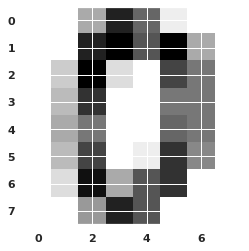

In [12]:
fig0

And here is the "mean" of $\X$
- Recall: we assume $\X$ has been zero-centered
- So the mean is subtracted before performing PCA
- Which means it has to be *added* to the reconstructed image

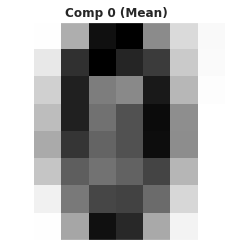

In [13]:
figm

And here are the Principal Components (new bases)
- We performed PCA with a reduced number of components ($r \lt n$)
- There are `n_components` such basis vector
- *Each* component is of length $n$, but there are only $r \lt n$ components

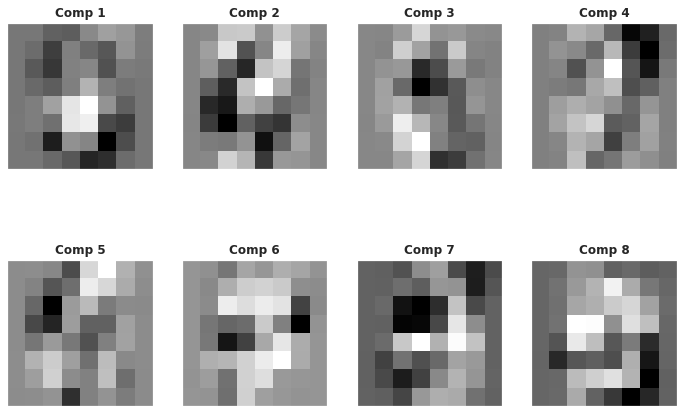

In [14]:
figc

It's not necessarily easy to interpret the components, particularly when $n$ is large
- Component 1 *might* be the "concept" corresponding to the digit 0
- Component 4 *might* be the "concept" corresponding to the digit 4
- The other components *might* be *partial* shape concept, rather than entire digits

Let's progressively examine the reconstruction using an increasing $r$ (number of synthetic features)
$$
\x^\ip = \sum_{j=1}^r { \tilde\x^\ip_j * (V^T)^{(j)} }
$$


It may be helpful to remind ourselves of the shapes of each element in the equation
- $\x^\ip$ is of length $n$
- The components $V^T$ are $(r \times n)$
    - Each component is of length $n$
    - There are $r \lt n$ components (e.g., $r = $ `n_components`)
- $\tilde\x^\ip$ is of length $r$

**Note**
- We treat the "mean $\X$ as component 0
- With weight 1
- So that it is "added back" into the reconstruction

So we construct an approximation of $\x^\ip$
- By adding weighted components $(V^T)^{(j)}$, each of length $n$
- The weight associated with component $j$ is $\tilde\x^\ip_j$
- So the sum is of length $n$

In [15]:
figi, axsi, fig_comp, axs_comp, x_tilde, error = rh_digits.show_recon(data_idx=data_idx)
plt.close(figi)
plt.close(fig_comp)

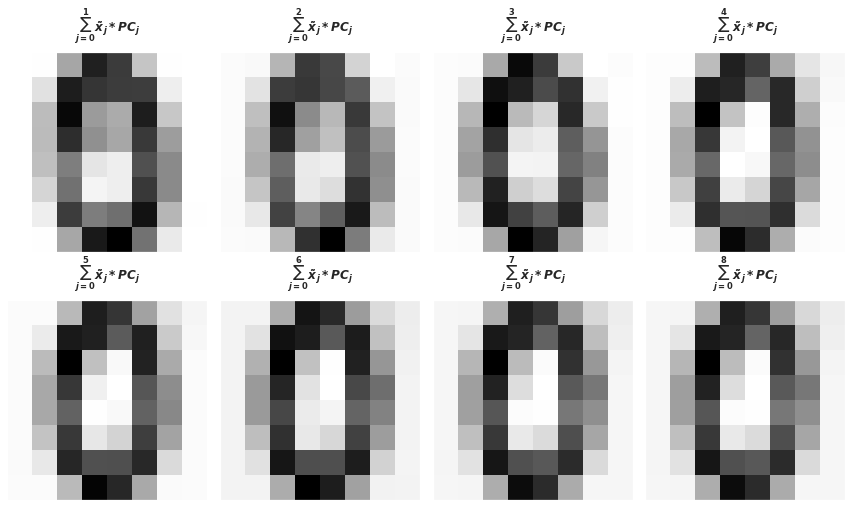

In [16]:
figi

You can see that the approximation using just the first component (and the mean)
- Is already a good approximation of $\x^\ip$
- Somewhat confirming our *guess* that component 1 represents the concept $0$

We can confirm this by looking at $\tilde\x^\ip$ numerically:

In [17]:
print("x tilde = ", x_tilde)

arg_max = np.argmax(x_tilde)
print("Largest feature at index {idx:d}".format(idx=arg_max+1))

x tilde =  [ 18.94187274   5.09552831 -11.11753549   6.39685469  -0.96245859
   3.24001397   2.51651326   0.05001587]
Largest feature at index 1


As you can see, the magnitude of $\tilde\x^\ip_1$ is the largest among $[ \tilde\x^\ip_j \, | \, 1 \le j \le r ]$

In fact, we might try to confirm our intuition 
- By examining $\tilde\x^{(i')}$ for all $i'$ where $\y^{(i')} = 0$ (assuming we have targets/labels)

In [18]:
# Get X tilde and the targets
Xtilde = rh_digits.dataProj
y = rh_digits.targets

# Filter to identify examples where target is equal to digit
digit = 0
mask = (y == digit)
Xtilde_digit = Xtilde[mask]

In [19]:
print("x tilde, when y=0:")

for i in range(0,10):
    print( [ "{x:3.2f}".format(x=x_tilde_j) for x_tilde_j in Xtilde_digit[i] ])

x tilde, when y=0:
['18.94', '5.10', '-11.12', '6.40', '-0.96', '3.24', '2.52', '0.05']
['10.94', '11.59', '-8.82', '8.34', '-6.50', '4.21', '4.25', '-4.37']
['15.16', '8.46', '-9.70', '2.85', '-3.39', '-5.13', '-3.80', '-7.11']
['21.68', '9.93', '-12.65', '3.27', '1.32', '4.85', '-0.82', '-3.95']
['13.36', '8.83', '-11.29', '4.24', '-0.35', '-1.18', '0.99', '-12.08']
['19.57', '7.25', '-9.87', '-3.35', '-1.75', '7.13', '4.04', '0.32']
['20.21', '9.81', '-7.81', '-2.10', '-2.19', '-1.39', '-0.83', '3.71']
['10.75', '12.33', '-9.70', '-1.01', '-4.82', '-7.07', '-4.91', '-12.87']
['17.96', '12.42', '-5.09', '-5.08', '2.47', '-8.20', '-2.86', '-11.06']
['22.48', '1.51', '-7.25', '-10.33', '3.19', '3.59', '0.20', '4.94']


As you can see
- For examples $\x^{(i')}$ where $\y^{(i')} = 0$
- $\tilde\x^{(i')}_1$ is the largest value in $\tilde\x^{(i')}$, for all $i'$ that we examined

Here is a comparison of the original $\x^\ip$ and its reconstructed approximation

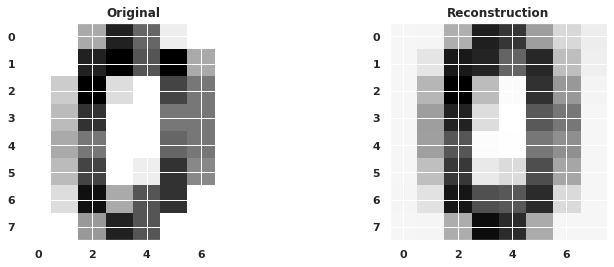

In [20]:
fig_comp

We could try to plot all our examples in $r$ dimensional space
- To see whether examples formed clusters (examples with similar feature vectors of length $r$

But $r =$ `n_components` is too large in our case; let's just plot using the first two features of $\tilde\x$

Number of examples: 718


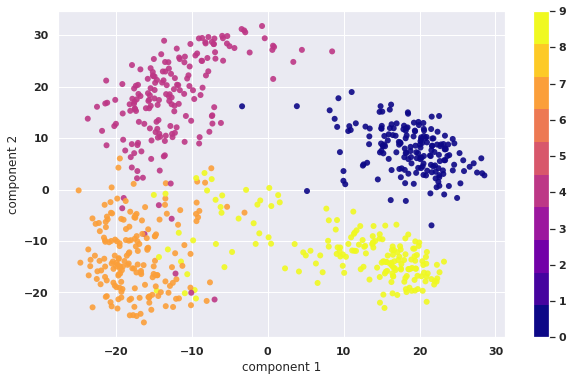

In [21]:
vpt = unsupervised_helper.VanderPlas()

print("Number of examples: {n:d}".format(n=Xtilde.shape[0]))
vpt.digits_subset_show_clustering(Xtilde, y, save_file="/tmp/digits_subset_cluster.jpg" )

Since we have targets/labels available (not generally the case for unsupervised learning)
- We can color the points according to their target
- We see that the 4 digits in the restricted examples cluster according to their features in $\tilde\x$
- Digit "0" is associated with (high $\tilde\x_1$, high $\tilde\x_2$)
- Digit "4" is associated with (low $\tilde\x_1$, high $\tilde\x_2$

<img src="images/Back_to_parent.jpg">

# Dimensionality reduction:examples

## MNIST example

In our introduction we illustrated representing MNIST digits
- With $r \approx 150$ synthetic features 
- Rather than $n = 28*28 =784$ original features.

Using the techniques illustrate for the "small digit subset" example above, you might
try to interpret the components
- We had argued that "blocks of dark pixels" in each corner was a source of redundancy
    - Was such a concept discovered by PCA ? Is it more subtle ?

This section of code should be a playground for you to experiment and deepen your understanding of PCA.

Here we provide some helper code.

First, retrieve the full MNIST dataset (70K samples)

We had previously used only a fraction in order to make our demo faster.

In [22]:
ush = unsupervised_helper.PCA_Helper()

X_mnist, y_mnist = ush.mnist_init()

Retrieving MNIST_784 from cache


In [23]:
from sklearn.model_selection import train_test_split
X_mnist.shape, y_mnist.shape
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist)
X_mnist_train.shape

((70000, 784), (70000,))

(52500, 784)

Perform PCA.

In [24]:
pca_mnist = ush.mnist_PCA(X_mnist_train)

In [25]:
pca_mnist.n_components_
X_mnist_train_reduced = ush.transform(X_mnist_train, pca_mnist)
X_mnist_train_reduced.shape

154

(52500, 154)

Let's plot the cumulative variance as a function of number of synthetic features.

This can help us determine how many synthetic features to keep.

To capture 95% of variance we need 154 synthetic features.


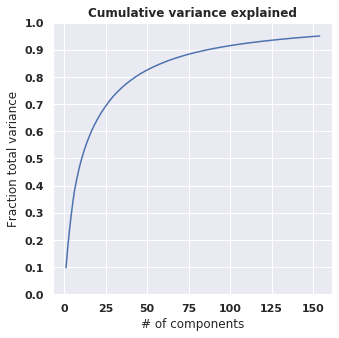

In [26]:
_ = ush.plot_cum_variance(pca_mnist)

variance_goal_pct = 95
features_for_goal = ush.num_components_for_cum_variance(pca_mnist, .01 * variance_goal_pct)
print("To capture {f:d}% of variance we need {d:d} synthetic features.".format(f=variance_goal_pct, d=features_for_goal))


So we need only about 20% of the original 784 features to capture 95% of the variance.

We can invert the PCA transformation to go from synthetic feature space back to original features.

That is, we can see what the digits look like when reconstructed from only 154 synthetic features.

First, let's look at the original:

(52500, 154)

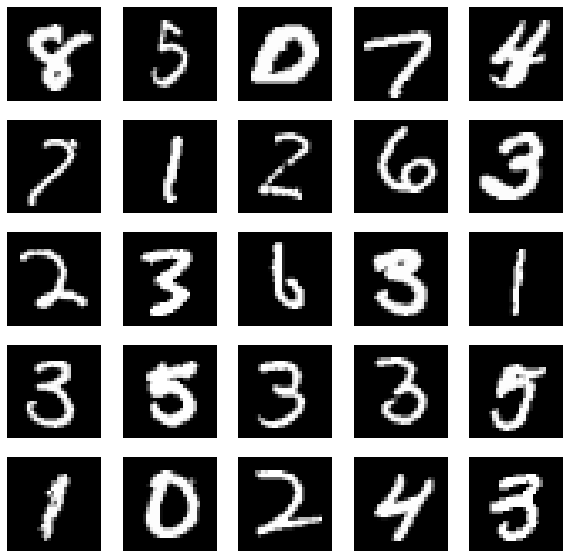

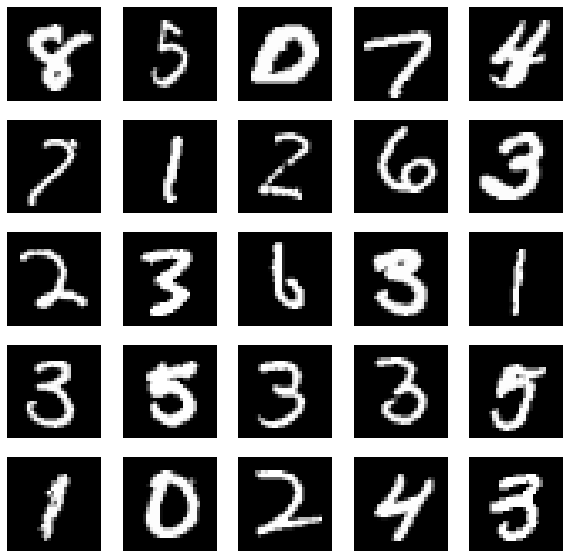

In [27]:

X_mnist_train_reduced = ush.transform(X_mnist_train, pca_mnist)
X_mnist_train_reduced.shape

# Show the original dataset
ush.mnh.visualize(X_mnist_train, y_mnist_train)

Next, the reconstructed

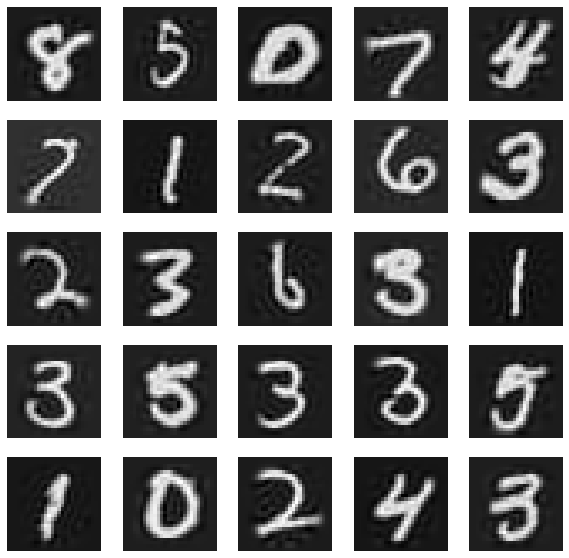

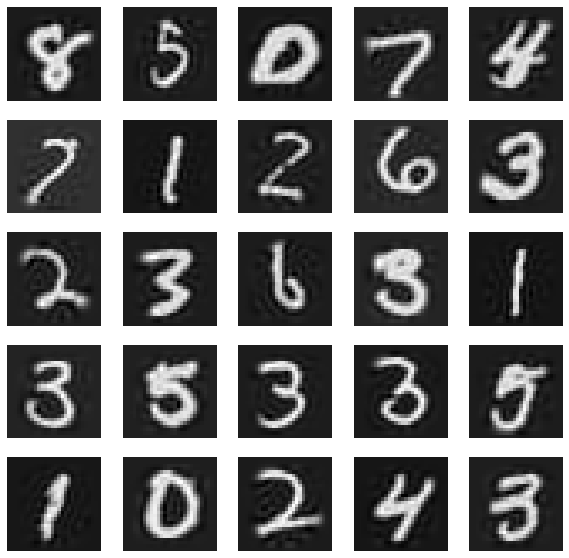

In [28]:
X_mnist_train_reconstruct = ush.inverse_transform(X_mnist_train_reduced, pca_mnist)
ush.mnh.visualize(X_mnist_train_reconstruct, y_mnist_train)

A little fuzzy, but pretty good.


Do the 10 digits form natural clusters (all images of the same digit in the same cluster) ?

Let's look at the training images when reduced to
only 2 synthetic features.  



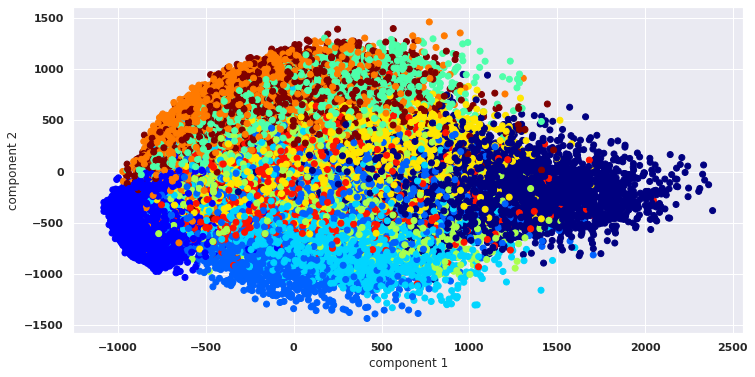

In [29]:
_ = ush.mnist_plot_2D(X_mnist_train_reduced, y_mnist_train.astype(int))

Each color is a different digit.

You can see that the clustering is far from perfect
- But also surprisingly good considering we're using only 2 out of 784 features

Let's see how much variance is captured by only the first two synthetic features.

In [30]:
cumvar_mnist = np.cumsum(pca_mnist.explained_variance_ratio_)
first_comp =2
cumvar_first = cumvar_mnist[first_comp-1]

print("Cumulative variance of {d:d} PC's is {p:.2f}%, about {n:.1f} pixels".format(
    d=first_comp, p=100 *cumvar_first, n=cumvar_first * X_mnist_train.shape[1]))


Cumulative variance of 2 PC's is 16.91%, about 132.5 pixels


Is 17% good ?  You bet !

With 784 original features (pixels)
- if each feature had equal importance, it would explain $1/784 = .12\%$ of the variance.  

So the first synthetic feature captures the variance of 132 original features 
- (assuming all were of equal importance).


<img src="images/Back_to_parent.jpg">

# PCA in Finance

## PCA of yield curve

[Litterman Scheinkman](https://www.math.nyu.edu/faculty/avellane/Litterman1991.pdf)

This is one of the most important papers (my opinion) in quantitative Fixed Income.

It allows us to hedge a large portfolio of bonds with a handful of instruments.


Before we show the result: why is this an important advance in Finance ?

- Imagine we had a large portfolio of bonds with many maturities.

- A common goal in Fixed Income Finance is to *immunize* (hedge) a portfolio to changes in the Yield Curve.

- A simple way to construct the hedge is to
    - Find the sensitivity of each bond in the portfolio to the $n = 14 $ "benchmark" maturities
    - Sum (over bonds in the portfolio) the individual bond sensitivities
    - Minus 1 times resulting portfolio sensitivity is the hedge that minimizes the portfolio's exposure to Yield Curve changes


But there are transaction costs (and complexity) with $n = 14$ bonds in the hedge portfolio.

Can we do nearly as well with $n' < n$ hedge bonds ?

That's exactly what PCA is designed for: dimensionality reduction.
- In this case, reducing the number of "benchmark" hedge bonds
- With minimal impact on immunization goal

Let's get the history of Yield Curves and look at first few examples.

In [31]:
ych = unsupervised_helper.YieldCurve_PCA()

# Get the yield curve data
data_yc = ych.create_data()
data_yc.head()

,1M,2M,3M,6M,1J,2J,3J,4J,5J,6J,7J,8J,9J,10J
1992-02-29,0.0961,0.09610,0.0961,0.0958,0.0898,0.0864,0.0849,0.0837,0.0826,0.0817,0.0810,0.0806,0.0803,0.0804
1992-03-31,0.0970,0.09700,0.0970,0.0969,0.0912,0.0889,0.0877,0.0864,0.0852,0.0841,0.0833,0.0827,0.0823,0.0823
1992-04-30,0.0975,0.09750,0.0975,0.0975,0.0920,0.0892,0.0877,0.0862,0.0848,0.0837,0.0828,0.0822,0.0817,0.0816
1992-05-31,0.0978,0.09785,0.0979,0.0979,0.0920,0.0889,0.0874,0.0860,0.0847,0.0836,0.0828,0.0821,0.0817,0.0815
1992-06-30,0.0974,0.09745,0.0975,0.0975,0.0931,0.0904,0.0889,0.0874,0.0860,0.0848,0.0839,0.0832,0.0827,0.0825


In [32]:
data_yc.shape

(287, 14)

Each example (row) has 14 features: the yields for 14 maturity points on a given date.

Let's plot the history of yield curves

/home/kjp/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


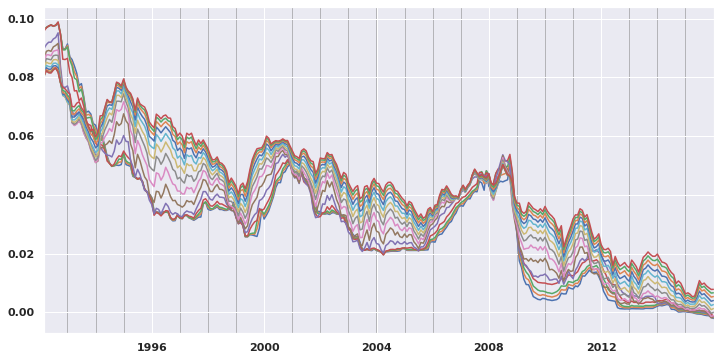

In [33]:
ych.plot_YC(data_yc)

Let's perform PCA on the **changes** in Yield Curve
- Just like in Supervised Learning, we sometimes need to transform the data before fitting a model
- The features we feed to PCA are *yield changes* rather than yields

So $n=14$ maturities, for $m$ samples (many years of daily data)


How many bonds (i.e, what is the $n'$) is "good enough" ?

The plot of cumulative variance explained, versus $n'$ will give us an answer.

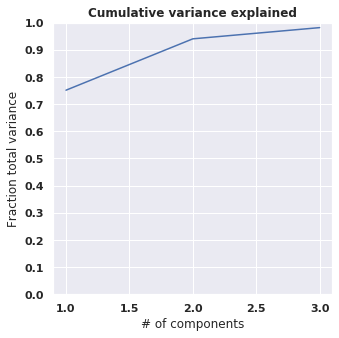

In [34]:
pca_yc, df_pca_yc = ych.doPCA(data_yc, doDiff=True)
_ = ych.plot_cum_variance(pca_yc)

Wow ! 

Only $n'=3$ synthetic features capture almost all the variance of the original $n =14$ features !

It gets even better !

By examining the composition of the synthetic features, we can *interpret* what they are 


Let's examine the effect of a 1 standard deviation move in each synthetic feature on
original features.  

We arrange the original features by maturity on the horizontal axis
and plot the effect on the vertical.

The choice to arrange the horizontal axis by maturity is *very deliberate*, as we will see.

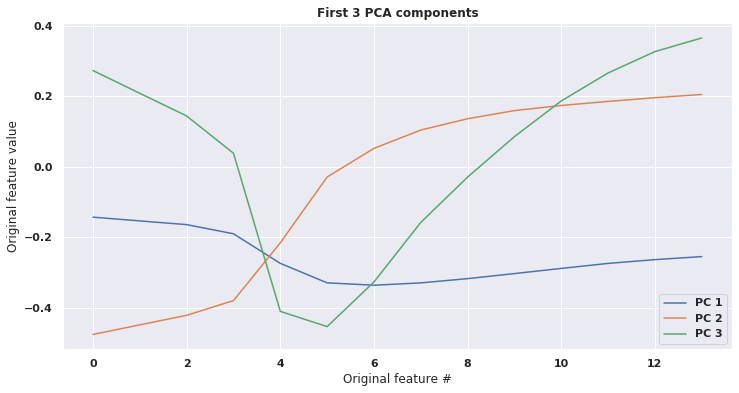

In [35]:
ych.plot_components(pca_yc)

This is a very typical pattern in Finance:
- The first synthetic feature affects all original features with roughly equal effect
- Higher synthetic features often express a *dichotomy*
    - Positive effect on some original features
    - Negative effect on other original features
    

In our case the original features are yield changes.

A unit standard deviation value of synthetic  feature $j$ (PCj) 
- $(j=1)$: affects all original features (yield change)  roughly equally
    - Corresponds to a parallel shift in the Yield Curve
- $(j=2)$: shows a dichotomy (of yield changes) between near and far maturities
    - Corresponds to the slope of the Yield Curve changing
- $(j=3)$: shows a dichotomy of yield changes of mid maturities versus extreme maturities
    - Corresponds to a twist in the Yield Curve about the 5 year maturity


**Recall**

The synthetic features are standardized, hence 1 unit is one standard deviation.

The $\Sigma$ matrix re-scales from standard deviation to original feature space.

- So can't compare the levels on the vertical axis between synthetic features.

    - Since $\sigma_1 > \sigma_2$ 
    - The absolute effect of synthetic feature 1 is greater than that of
synthetic feature 2 
    - For a 1 standard deviation move in each.

We started with a complicated example (Yield Curve with $n=14$ features)
- can almost completely explain
(changes in the Yield Curve) with 3 intuitive market changes
    - Parallel Shift up/down of all maturities
    - Long end versus short end changes (slope)
    - Twist at intermediate maturity

That's interesting from a Machine Learning perspective but important for Finance:
- It shows show to construct efficient Hedge Portfolios.

Suppose we have a Target Portfolio consisting of long positions in many bonds, with many maturities.

Our goal is to construct another portfolio (the Hedge Portfolio)
- Consisting of a small number of bonds
- With the *same* sensitivity to Yield Curve changes as the Target Portfolio 

By combining a long position in the Target Portfolio with a short position in the Hedge Portfolio
- The resulting Net Portfolio is immunized (hedged) to changes in the Yield Curve

If we can re-express our Target Portfolio in terms of synthetic features
- We can construct the Hedging Portfolio as one consisting only of 3 synthetic bonds
- In quantities that mimic the sensitivity of the Target Portfolio to the first 3 PCs.
    - Since the PCs are *independent*, this is easy
    - Normally:  you would need to solve
         -  a system of 3 equations in 3 unknowns (size of position in each synthetic bond)

The catch is that each synthetic bond (feature) is a linear combination of $n=14$ real bonds.

So we would need $n$ real bonds to create each synthetic.

One way to deal with this is to project the synthetic features onto $n'' < 14$ real bonds.

So we come up with "approximate" versions of the synthetic features themselves.

The interpretation of Yield Curve changes guides us into a simpler hedge
- Hedge the parallel shift with the 10 year Treasury (most liquid bond in the US)
    - works because all yield changes roughly the same for first PC
- Hedge the slope with a long/short portfolio of 2 year/30 year (or 10 year) bonds
    - also liquid instruments, that are "close enough" to PC 2
- Hedge the twist with a butterfly of long 2 year/10 year, short 5 year

So our Hedging Portfolio will consist of just a handful of very liquid bonds
- As opposed to $n= 14$ bonds, many of which may be illiquid


The primary way of hedging Fixed Income portfolios prior to this was by
*duration* hedging
- Assuming that yields across all maturities moved the same amount
- Using a single liquid bond as the Hedge Portfolio

The PCA verified that the simple, intuitive hedge was actually the most important hedge to make !

### Finance details

This section has little to do with Machine Learning but quite a bit to do with Fixed Income Finance.

- We have captured changes in *yield* of a bond
- To hedge *price* changes (our goal) we still need to translate a yield change to a price change

- For bond $b$ with price $P_b$ and yield $y_b$ 
    - We need $\frac{\partial P_b}{\partial y_b}$
        - the change in Price of bond $b$ per unit change in its yield
    - This is known as the bond's *duration*
    - If we hold $\#_b$ units of bond $b$ in a Portfolio
        - the bond's contribution to portfolio price change is $\#_b$ times the above sensitivity
    - Sometimes more convenient to compute the *percent price* change per unit yield change
        - size of the hedge now in *number of dollars* rather than *number of bonds*
 

## PCA of the SP 500

The same analysis that we did for the Bond Universe works for other instruments.

Consider a universe of all stocks in a particular stock universe.

We can perform PCA on the returns (percent changes) of each stock
- Discover the common factors affecting all stocks in the universe.
- $n = 500$ features, for each example (one day return)

We don't have time to do it here, but the first components of many universes tends to be
- A first ("most important") component that has roughly equal impact
    - PC 1 is almost an equally weighted portfolio of all stocks
- Higher components expressing dichotomies
    - Cyclical stocks versus non-cyclical
    - Large cap versus small cap
    - Industry versus other industry
    

## Interpretting the PC's

The key in our interpretation of the PCs for the Yield Curve
- Choice of
ordering our original features by sorted maturity.

Had we chosen some other arrangement of the horizontal axis, we may not have seen the pattern.

So how do we find the "right" pattern ?

- Assign each original feature a set of attributes
    - Bonds: maturity
    - Stocks: industry, market capitalization
- Propose a "theory" about how the value of an original feature will respond to a level of the PC j
    - The theory should relate the attribute of an original feature to the value of feature
- As a horizontal axis: sort by the attribute proposed by your theory
    - Stocks:
        - $(j=1)$: arbitrary arrangement works, since all stocks responds equally
        - $(j>1)$: cluster stocks by attribute
            - Sort by market capitalization
            - Group by industry: first all Industrials, then all Techs, etc.

Let $\hat{u}$ be the $1 \times n$ vector of all $0$'s except for a $1$ at position $i$
$$
\begin{array}{lll}
\hat{u}_i & = & 1 \\
\hat{u}_j & = & 0, \hspace{3ex} j \ne i
\end{array}
$$

Then
$$
s = \hat{u} I V^T
$$
is a $1 \times n$ vector whose elements are the effect of a one standard deviation shock in synthetic factor $i$ on each original feature.
$$
s_j = \text{change in } X_j \text{ for a 1 standard deviation change in } \tilde{X_i}
$$

$$
s' = \hat{u} \Sigma V^T
$$
is a $1 \times n$ vector that is scaled by the actual standard deviation of $\tilde{X}_i$ since the absolute size of a 1 standard deviation change in $\tilde{X}_i$ is $\sigma_i$.

That is:
row $i$ of $V^T$ is the effect on each original feature of a one standard deviation shock in synthetic feature $\tilde{X}_i$.

<img src="images/Back_to_parent.jpg">

# Recommender Systems: Pseudo SVD

There is another interesting use of Matrix Factorization that we will briefly review.

It will show both a case study and interesting extension of SVD.

## Netflix Prize competition
- Predict user ratings for movies
- Dataset
    - Ratings assigned by users to movies: 1 to 5 stars
    - 480K users, 18K movies; 100MM ratings total
- $1MM prize
- Awarded to team that beat Netflix existing prediction system by at least 10 percentage points

## User preference matrix

We will try to use same language as PCA (examples, features, synthetic features)
- But map them to Netflix terms
    - Examples: Viewers
    - Features: Movies ("items")

Matrix $\X$: user rating of movies

$\X_j^{(i)}$ is $i^{\text{th}}$ user's rating of movie $j$

$\X$ is huge: $m *n$
- $m = .5$ million viewers
- $n = 18,000$ items (movies).

About 9 billion entries for a full matrix !


## Idea: Linking Viewer to Movies via concepts

- Come up with your own "concepts" (synthetic features)
    - Concept = attribute of a movie
        - Map user preference to concept
        - Map movie style to concept
        - Supply and demand: 
            - User demands concept, Movie provides concept

### Human defined concepts
- Style: Action, Adventure, Comedy, Sci-fi
- Actor
- Typical audience segment

### Making recommendations based on concepts
- Create user profile $P$: maps user to concept
- Create item profile $Q$: maps movies (features, items) to concept
- $\X = P Q^T$

To "recommend" a movie to a new user
- Given a sparse feature vector for the new user
- Obtain a dense vector
    - By mapping the sparse vector to concept space (synthetic features)
    - Finding a cluster of similar synthetic feature vectors, summarizing
    - Inverse transformation back to original features
    
The original features (movies) newly populated in the formerly sparse vector 
are the recommendations

One advantage of the $\X = P Q^T$ approach is a big space reduction.

With $k \le n$ concepts:
- $\X$ is $m \times n$
- $P$ is $m \times k$
- $Q$ is $n \times k$


### SVD to discover concepts

Why let a human guess concepts when Machine Learning can discover them ?  
- Factor $\X$ by SVD !
    - Let SVD discovers the $k$ "best" synthetic features, rather than leaving it to a human




Here's how to use SVD to discover $P, Q$:

$$
\begin{array}[lll]\\
\X & = & U \Sigma  V^T & \text{ SVD of } \X \\
& = & (U \Sigma)  V^T \\
& = & P Q & \text{ Letting }, P = U \Sigma, Q = V^T \\
\end{array}
$$


Anyone spot the problem(s) ?

The matrix $\X$ with 9 billion entries is a handful !

But the problem is more acute than one of size.

Each row $\X^\ip$ is *sparse*
- Any single user views only a fraction of the $n$ movies

How can we perform SVD on a matrix with missing values ?

Missing value imputation is not attractive
- Of the $9$ billion potential entries in $\X$, only $100$ million are defined
- Would impute more missing values than actual values

What can we do ?

**The ML mantra**
- It's all about the Loss function
- The essence of ML is finding a Loss function that describes a solution to your problem
- Gradient Descent is the "Swiss Army Knife" used for optimization of Loss functions

We will use "Pseudo SVD", a form of matrix decomposition based on minimizing a Loss.

## Pseudo SVD Loss function

The Froebenius Norm 
- Used in PCA as a metric with which to find the "best" low rank approximation
- Is modified to exclude missing values

$$
\begin{array}\\
\loss(\X',\X) & = & \sum\limits_{\substack{1 \le i \le m,\\ 1 \le j \le n \\ \X_j^{(i)} \text{defined}}} { \left(  \X_j^{(i)} - {\X'}_j^{(i)} \right)^2} 
\end{array}
$$

That is: the loss is computed *only for the defined entries* of $\X$.

We can interpret the loss as a Reconstruction Error

Note that $\loss(\X',\X)$ is parameterized by $P, Q$

$$
\begin{array}\\
\loss(\X',\X) & = & \sum\limits_{\substack{1 \le i \le m,\\ 1 \le j \le n \\ \X_j^{(i)} \text{defined}}} { \left(  \X_j^{(i)} - {\X'}_j^{(i)} \right)^2} \\
& = & \sum\limits_{\substack{1 \le i \le m,\\ 1 \le j \le n \\ \X_j^{(i)} \text{defined}}} { \left(  \X_j^{(i)} - (P Q^T)_j^{(i)} \right)^2} & \text{ since } \X' = P Q^T \\
\end{array}
$$

$P, Q$ are our *parameters* (e.g., $\Theta$)

So we search for the $P^*, Q^*$ that minimize $\loss(\X',\X)$
$$
P^*, Q^* = \argmin{P,Q} \loss(\X',\X) 
$$

How ? Gradient Descent !

### Pseudo SVD algorithm

- Define $\X' = P Q^T$

- Initialize elements of $P, Q$ randomly.

- Take analytic derivatives of $\loss(\X',\X) $ with respect to
    - $P_j^{(i)}$ for $1 \le i \le m, 1 \le j \le k$
    - $Q_j^{(i)}$ for $1 \le i \le m, 1 \le j \le k$

- Use Gradient Descent to solve for optimal entries of $P, Q$.
    - Find entries of $P, Q$ such that product matches non-empty part of $\X$

**Note**
- No guarantee that the $P, Q$ obtained are
    - Orthonormal, etc. (which SVD would give you)

But SVD won't work for $\X$ with missing values.

### Filling in missing values

Once you have $P, Q$

- to predict a missing rating for user $i$ movie $j$:

$$\hat{r}_{j,i} =  q^\ip \cdot p_j^T$$ 
- $q^\ip$ is row $i$ of $Q$
- $p_j$ is column $j$ of $P^T$

### Some intuition

The rating vector of a user may have missing entries.

But we can still project to synthetic feature space based on the non-empty entries.

The projection winds up in a "neighborhood" of concepts.

Inverse transformation 
- Gets us to a completely non-empty rating vector that is a resident of this neighborhood.

**Example**

User rates 
- Sci-Fi movies A and B very highly 
- Does not rate Sci-Fi movie C.

Since A,B, C express same concept (Sci-Fi) they will be close in synthetic feature space.

Hence, the implied rating of User for movie C will be close to what other users rate C.

In [36]:
print("Done")

Done
